# Sleep Data Analysis
Justin Yi  
4/22/25  
CPSC 222
Spring 2025
Description:  
This Jupyter Notebook explores, interprets, and learns my sleep data.

In [190]:
import utils
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import importlib
import datetime as dt

importlib.reload(utils)

<module 'utils' from 'd:\\School\\Spring 2025\\Intro to Data Science\\Data Assignments\\Project\\utils.py'>

## Overview
The two datasets we'll be combining and analyzing are my personal sleep data from my time here at GU, collected by Fitbit, and weather data of Spokane courtesty of MeteoStat API. This Notebook will walk you through my cleaning, EDA, and statistical analysis. Let's take a look at what we have:

In [191]:
sleep_df = pd.read_csv("sleep_score.csv")
weather_df = utils.get_spokane_weather_df()
weather_df.to_csv("initial_spokane_weather.csv")
print(sleep_df.head())
print(weather_df.head())

   sleep_log_entry_id             timestamp  overall_score  composition_score  \
0         48988871406  2025-04-16T06:58:30Z             76                NaN   
1         48977379538  2025-04-15T08:18:30Z             71                NaN   
2         48967692815  2025-04-14T09:27:30Z             84                NaN   
3         48959170544  2025-04-13T07:16:00Z             73                NaN   
4         48948016693  2025-04-12T05:12:30Z             70                NaN   

   revitalization_score  duration_score  deep_sleep_in_minutes  \
0                    76             NaN                   55.0   
1                    71             NaN                   59.0   
2                    84             NaN                  122.0   
3                    73             NaN                   79.0   
4                    70             NaN                   14.0   

   resting_heart_rate  restlessness  
0                  64      0.083240  
1                  65      0.093929  
2 

## Cleaning and Preparation
I'd like to join both DataFrames on their date columns to get a bigger, combined dataset, but there's some cleaning we need to do:
1. For sleep_df:
    * We can drop the sleep_log_entry_id column because they serve no predictive purpose and the dates already serve as unique keys
    * We should drop instances that occur before 2023-08-26 (my first move-in day)
    * We should remove the timestamps, keep the dates, and rename the "timestamp" column to "date"
    * (I will be doing this later.) For classification purposes, let's decode my overall sleep scores based on [Fitbit's calculation method](https://support.google.com/fitbit/answer/14236513?hl=en#zippy=%2Cwhats-my-fitbit-sleep-score%2Chow-is-my-sleep-score-calculated-in-the-fitbit-app)
        * 90-100: Excellent
        * 80-89: Good
        * 60-79: Fair
        * <60: Poor
        * According to Fitbit: "Your overall nightly sleep score is based on your heart rate, the time you spend awake or restless, and your sleep stages."
1. For weather_df:
    * We can drop the "00:00:00" from every date because it's constant and we want consistency with sleep_df's date column
1. We should also drop completely empty columns in both DataFrames because interpolation is literally impossible with them and they serve no purpose
1. We should also interpolate missing values for both DataFrames. We should also use `ffill()` and `bbfill()`as a precaution for missing beginning and ending values.

In [192]:
# Cleaning sleep_df
#1 Dropping ID column
sleep_df = utils.drop_column(sleep_df, "sleep_log_entry_id")
#2 Drop undesired rows
sleep_df = utils.drop_rows_by_starting_index(sleep_df, 518, 743)
#3 Clean timestamps
sleep_df = utils.remove_string_ends(sleep_df, "timestamp", 10)
sleep_df.rename(columns={"timestamp": "date"}, inplace=True)
#4 Remove the empty columns
sleep_df = utils.drop_empty_columns(sleep_df)
#5 Address missing value on 2025-03-08; we'll interpolate
sleep_df = utils.fill_missing_values(sleep_df)

sleep_df.to_csv("cleaned_sleep_score.csv")

d:\School\Spring 2025\Intro to Data Science\Data Assignments\Project\utils.py:39: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method="linear", inplace=True)


I initially tried using `pd.mask()` to decode my sleep scores, but I couldn't replace all values at the same time. Thankfully, I was able to use lists and `pd.replace()` to do so.

In [193]:
# Cleaning weather 
#1 Clean the date column
weather_df = utils.remove_string_ends(weather_df, "date", 10)
#2 Remove the empty columns
weather_df = utils.drop_empty_columns(weather_df)
#3 Fill empty data
weather_df = utils.fill_missing_values(weather_df)

weather_df.to_csv("cleaned_spokane_weather.csv")

d:\School\Spring 2025\Intro to Data Science\Data Assignments\Project\utils.py:39: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method="linear", inplace=True)


We can now perform an inner join of the two DataFrames on the "date" column.

In [194]:
# Joining both datasets
merged_df = sleep_df.merge(weather_df, on=["date"], how="inner")
merged_df.set_index("date", inplace=True)

There are a couple of other things I want to do before EDA:
1. Split up the DataFrame into semester groups
    * They will be used for hypothesis testing
    * Converting the indexes to datetime objects prevents splitting up by indices
    * I'd also like to concatenate the semester groups to create a full Gonzaga group (omitting summer and Christmas Break)
1. Convert the "date" column to a datetime object and extract the day, month, and year columns.
    * This will allow us to plot without issues
    * We can then aggregate by month
    * It'll also allow us to compare the stats by year

In [195]:
# Semester groups
# Note: slice from soonest to latest because that's how the df is designed
fall_2023 = merged_df.loc["2023-12-12" : "2023-08-26"]
fall_2023.to_csv("Fall 2023.csv")
spring_2024 = merged_df.loc["2024-05-09" : "2024-01-14"]
spring_2024.to_csv("Spring 2024.csv")
fall_2024 = merged_df.loc["2024-12-12" : "2024-08-26"]
fall_2024.to_csv("Fall 2024.csv")
spring_2025 = merged_df.loc["2025-05-09" : "2025-01-14"]
spring_2025.to_csv("Spring 2025.csv")
just_school = pd.concat([spring_2025, fall_2024, spring_2024, fall_2023])

In [196]:
# Pandas datetime object
initial_merged_df = utils.create_datetime_columns(merged_df).copy()
initial_merged_df.to_csv("initial merged_df.csv")
just_school = utils.create_datetime_columns(just_school)
just_school.to_csv("Just School.csv")
# Aggregate by month
merged_df = merged_df.resample("MS").mean()
dates = [d.strftime("%m-%Y") for d in merged_df.index]

The biggest challenge with cleaning was relearning and applying new techniques I haven't applied before.

## Exploratory Data Analysis
Now that our dataset is ready, we can begin exploring and understanding it. Let's get a general view of our features by using `pd.decribe` making line graphs and bar graphs:

In [197]:
# Overall Stats
just_school.describe()

,year,month,day,overall_score,revitalization_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,tavg,tmin,tmax,prcp,wdir,wspd,pres
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,2023.965699,6.530343,15.614776,74.511873,74.511873,68.010554,63.440633,0.094924,46.243272,37.807388,55.729288,0.059570,155.316623,3.966491,1016.852243
std,0.679546,3.821549,9.002609,7.081292,7.081292,24.286646,3.272223,0.024971,13.599413,11.506175,17.182194,0.124224,135.482534,2.948711,7.738187
min,2023.000000,1.000000,1.000000,43.000000,43.000000,9.000000,55.000000,0.038409,3.700000,-0.900000,10.000000,0.000000,0.000000,0.000000,996.300000
25%,2024.000000,3.000000,8.000000,70.000000,70.000000,52.000000,62.000000,0.079879,37.200000,30.900000,43.000000,0.000000,14.000000,1.600000,1011.650000
50%,2024.000000,8.000000,15.000000,75.000000,75.000000,68.000000,64.000000,0.092105,44.600000,37.000000,53.100000,0.000000,190.000000,3.100000,1015.900000
75%,2024.000000,10.000000,24.000000,79.000000,79.000000,81.000000,65.000000,0.106627,55.650000,45.000000,69.100000,0.053889,274.500000,5.700000,1021.450000
max,2025.000000,12.000000,31.000000,91.000000,91.000000,135.000000,74.000000,0.220697,77.200000,66.000000,99.000000,0.846000,360.000000,14.000000,1042.100000


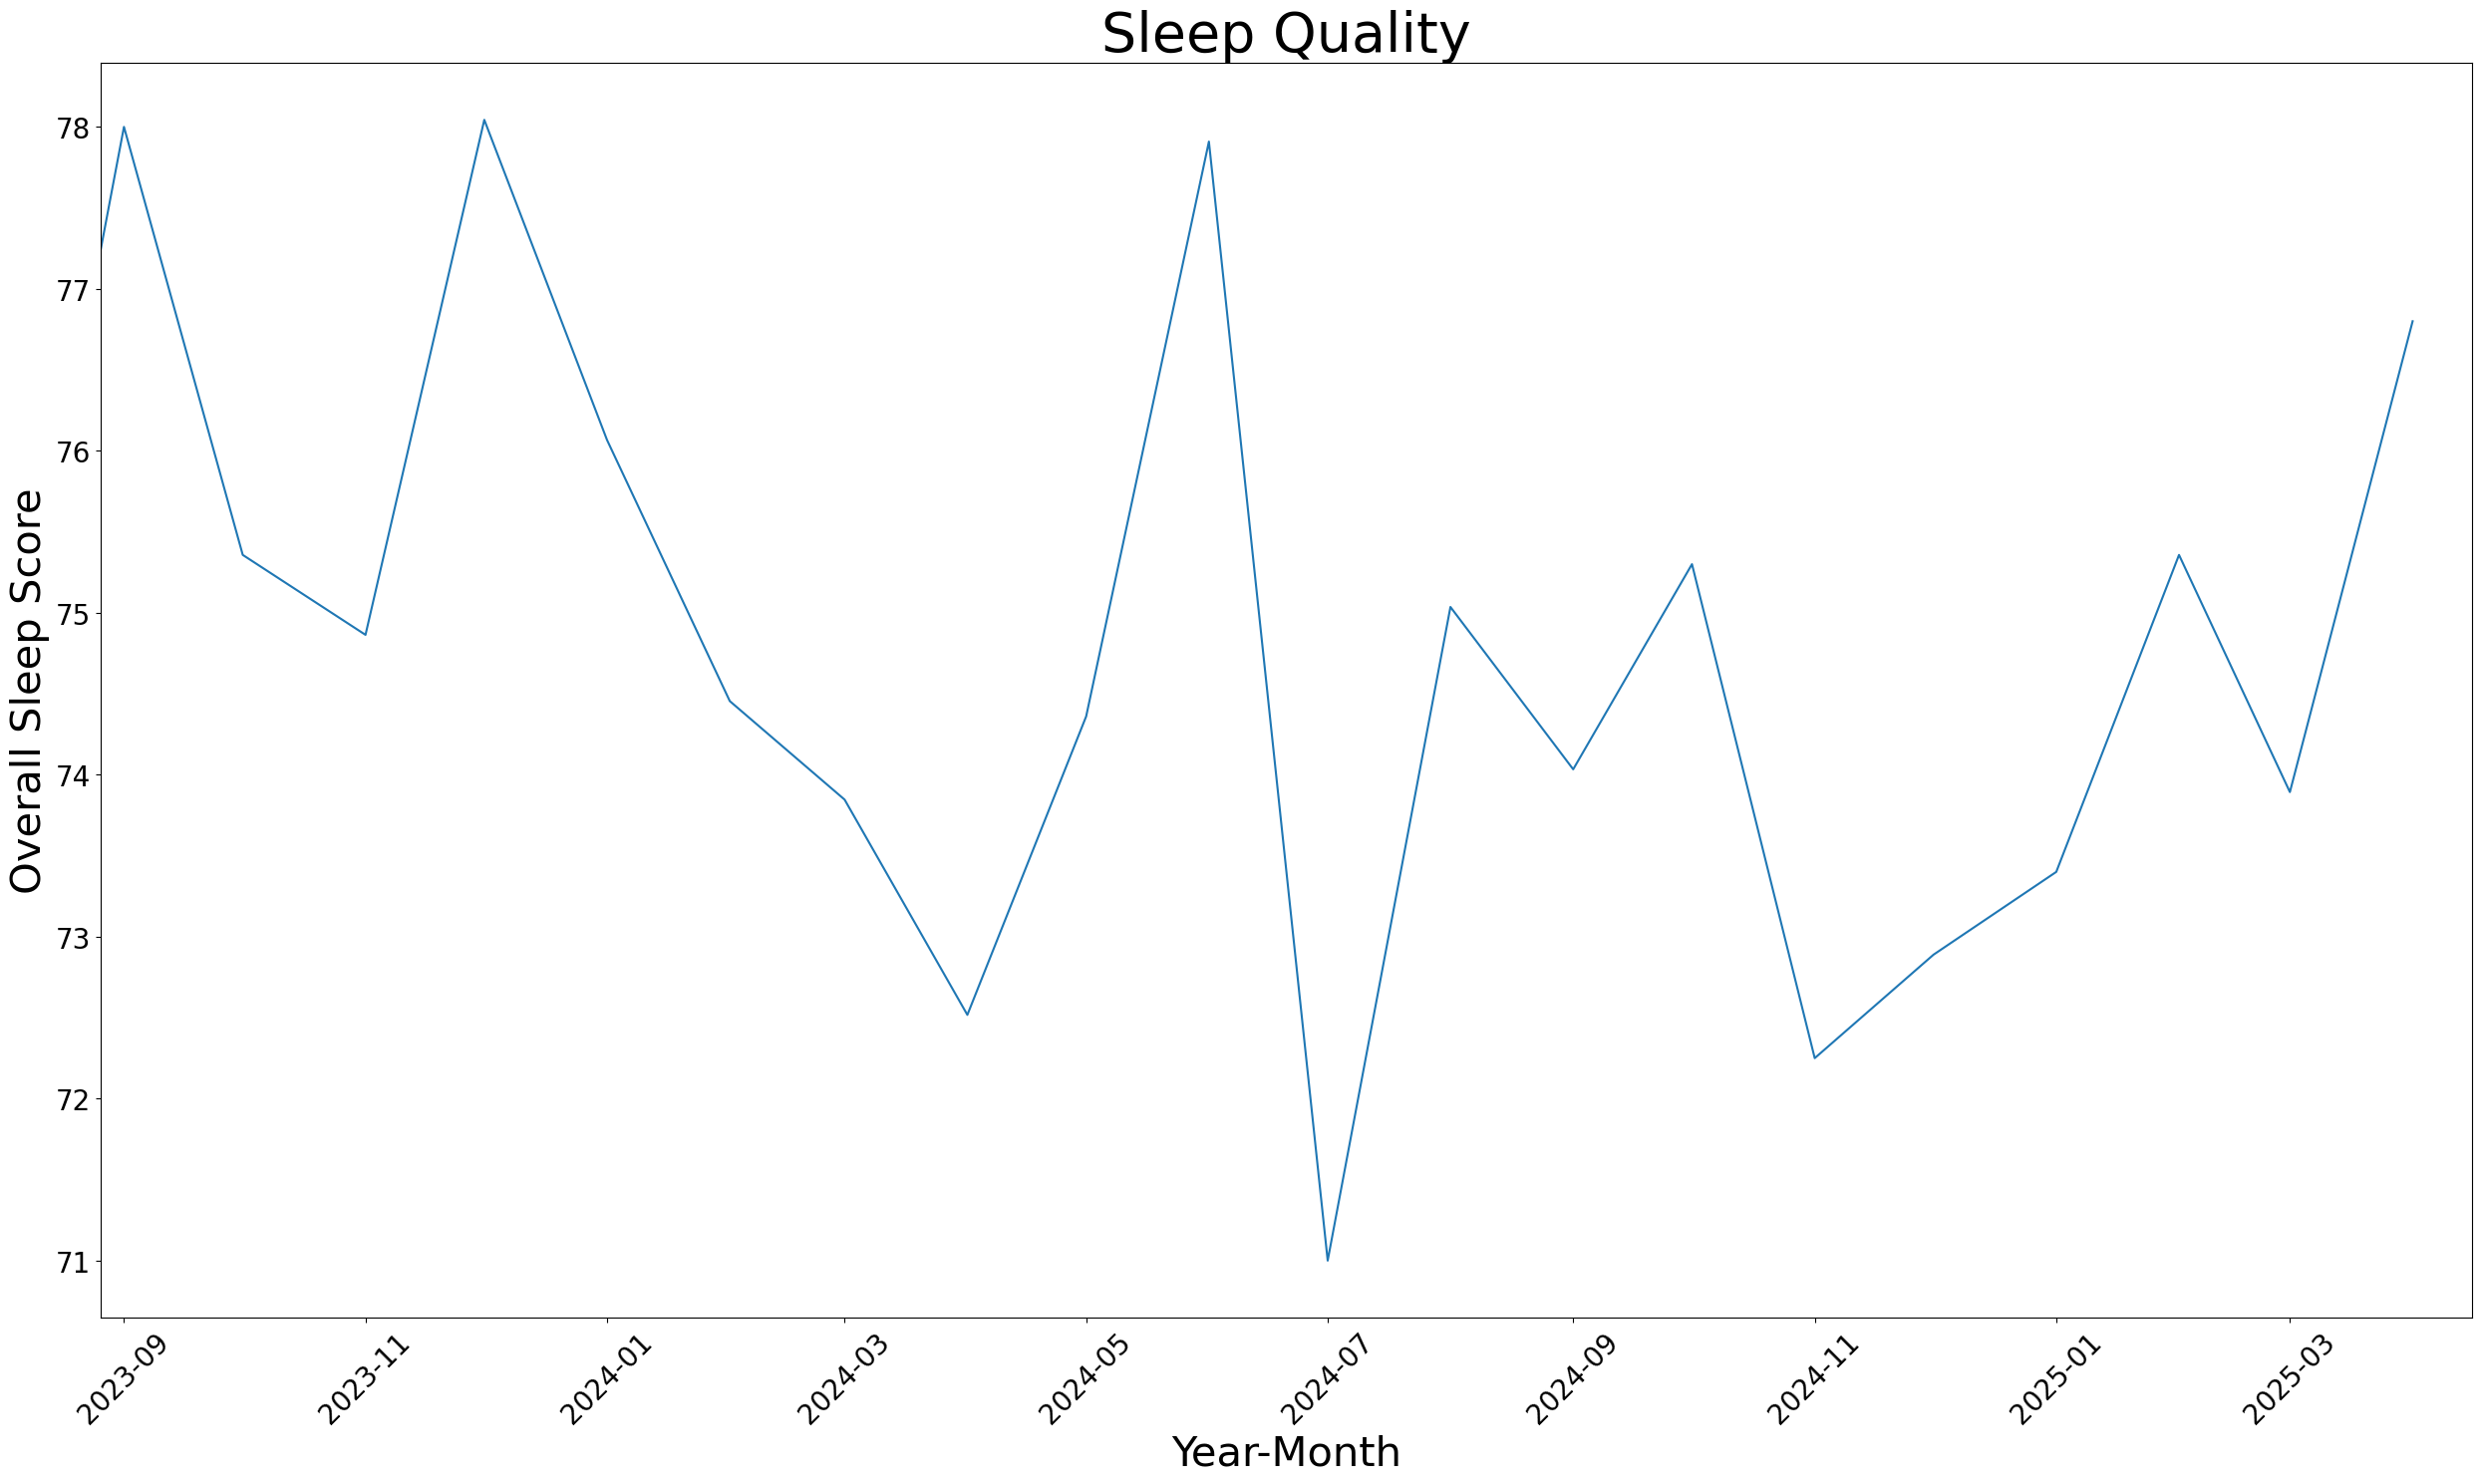

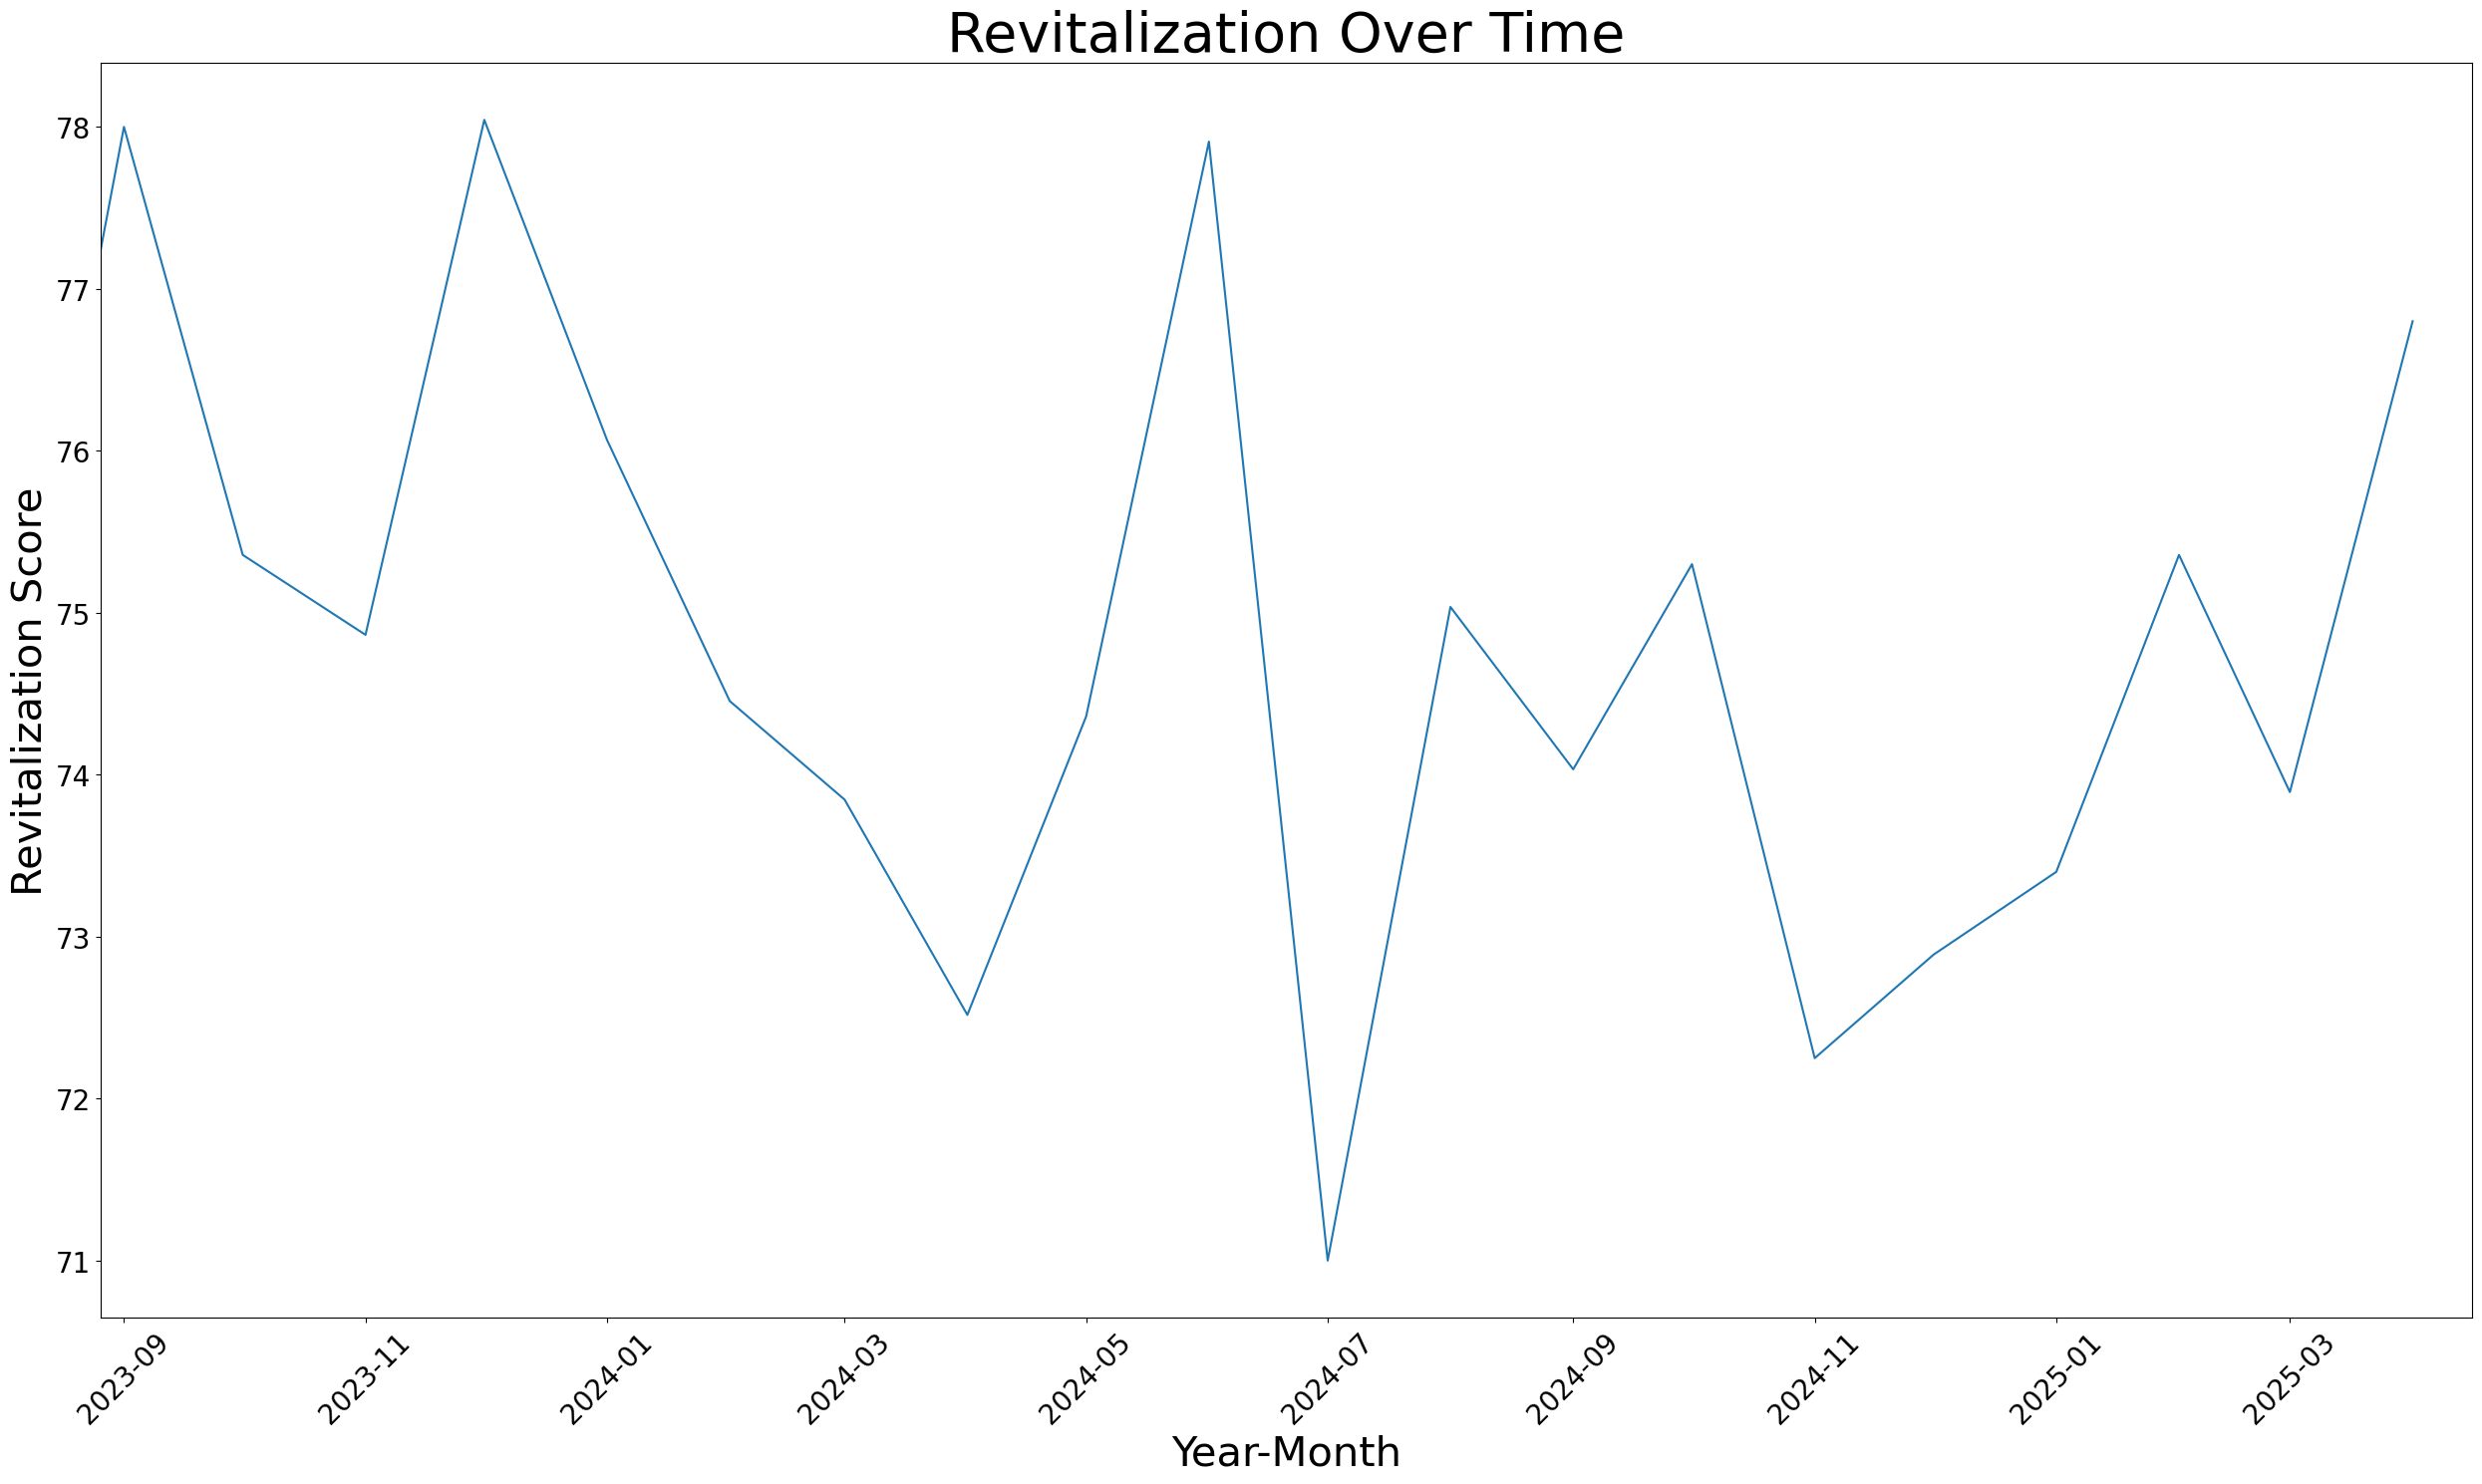

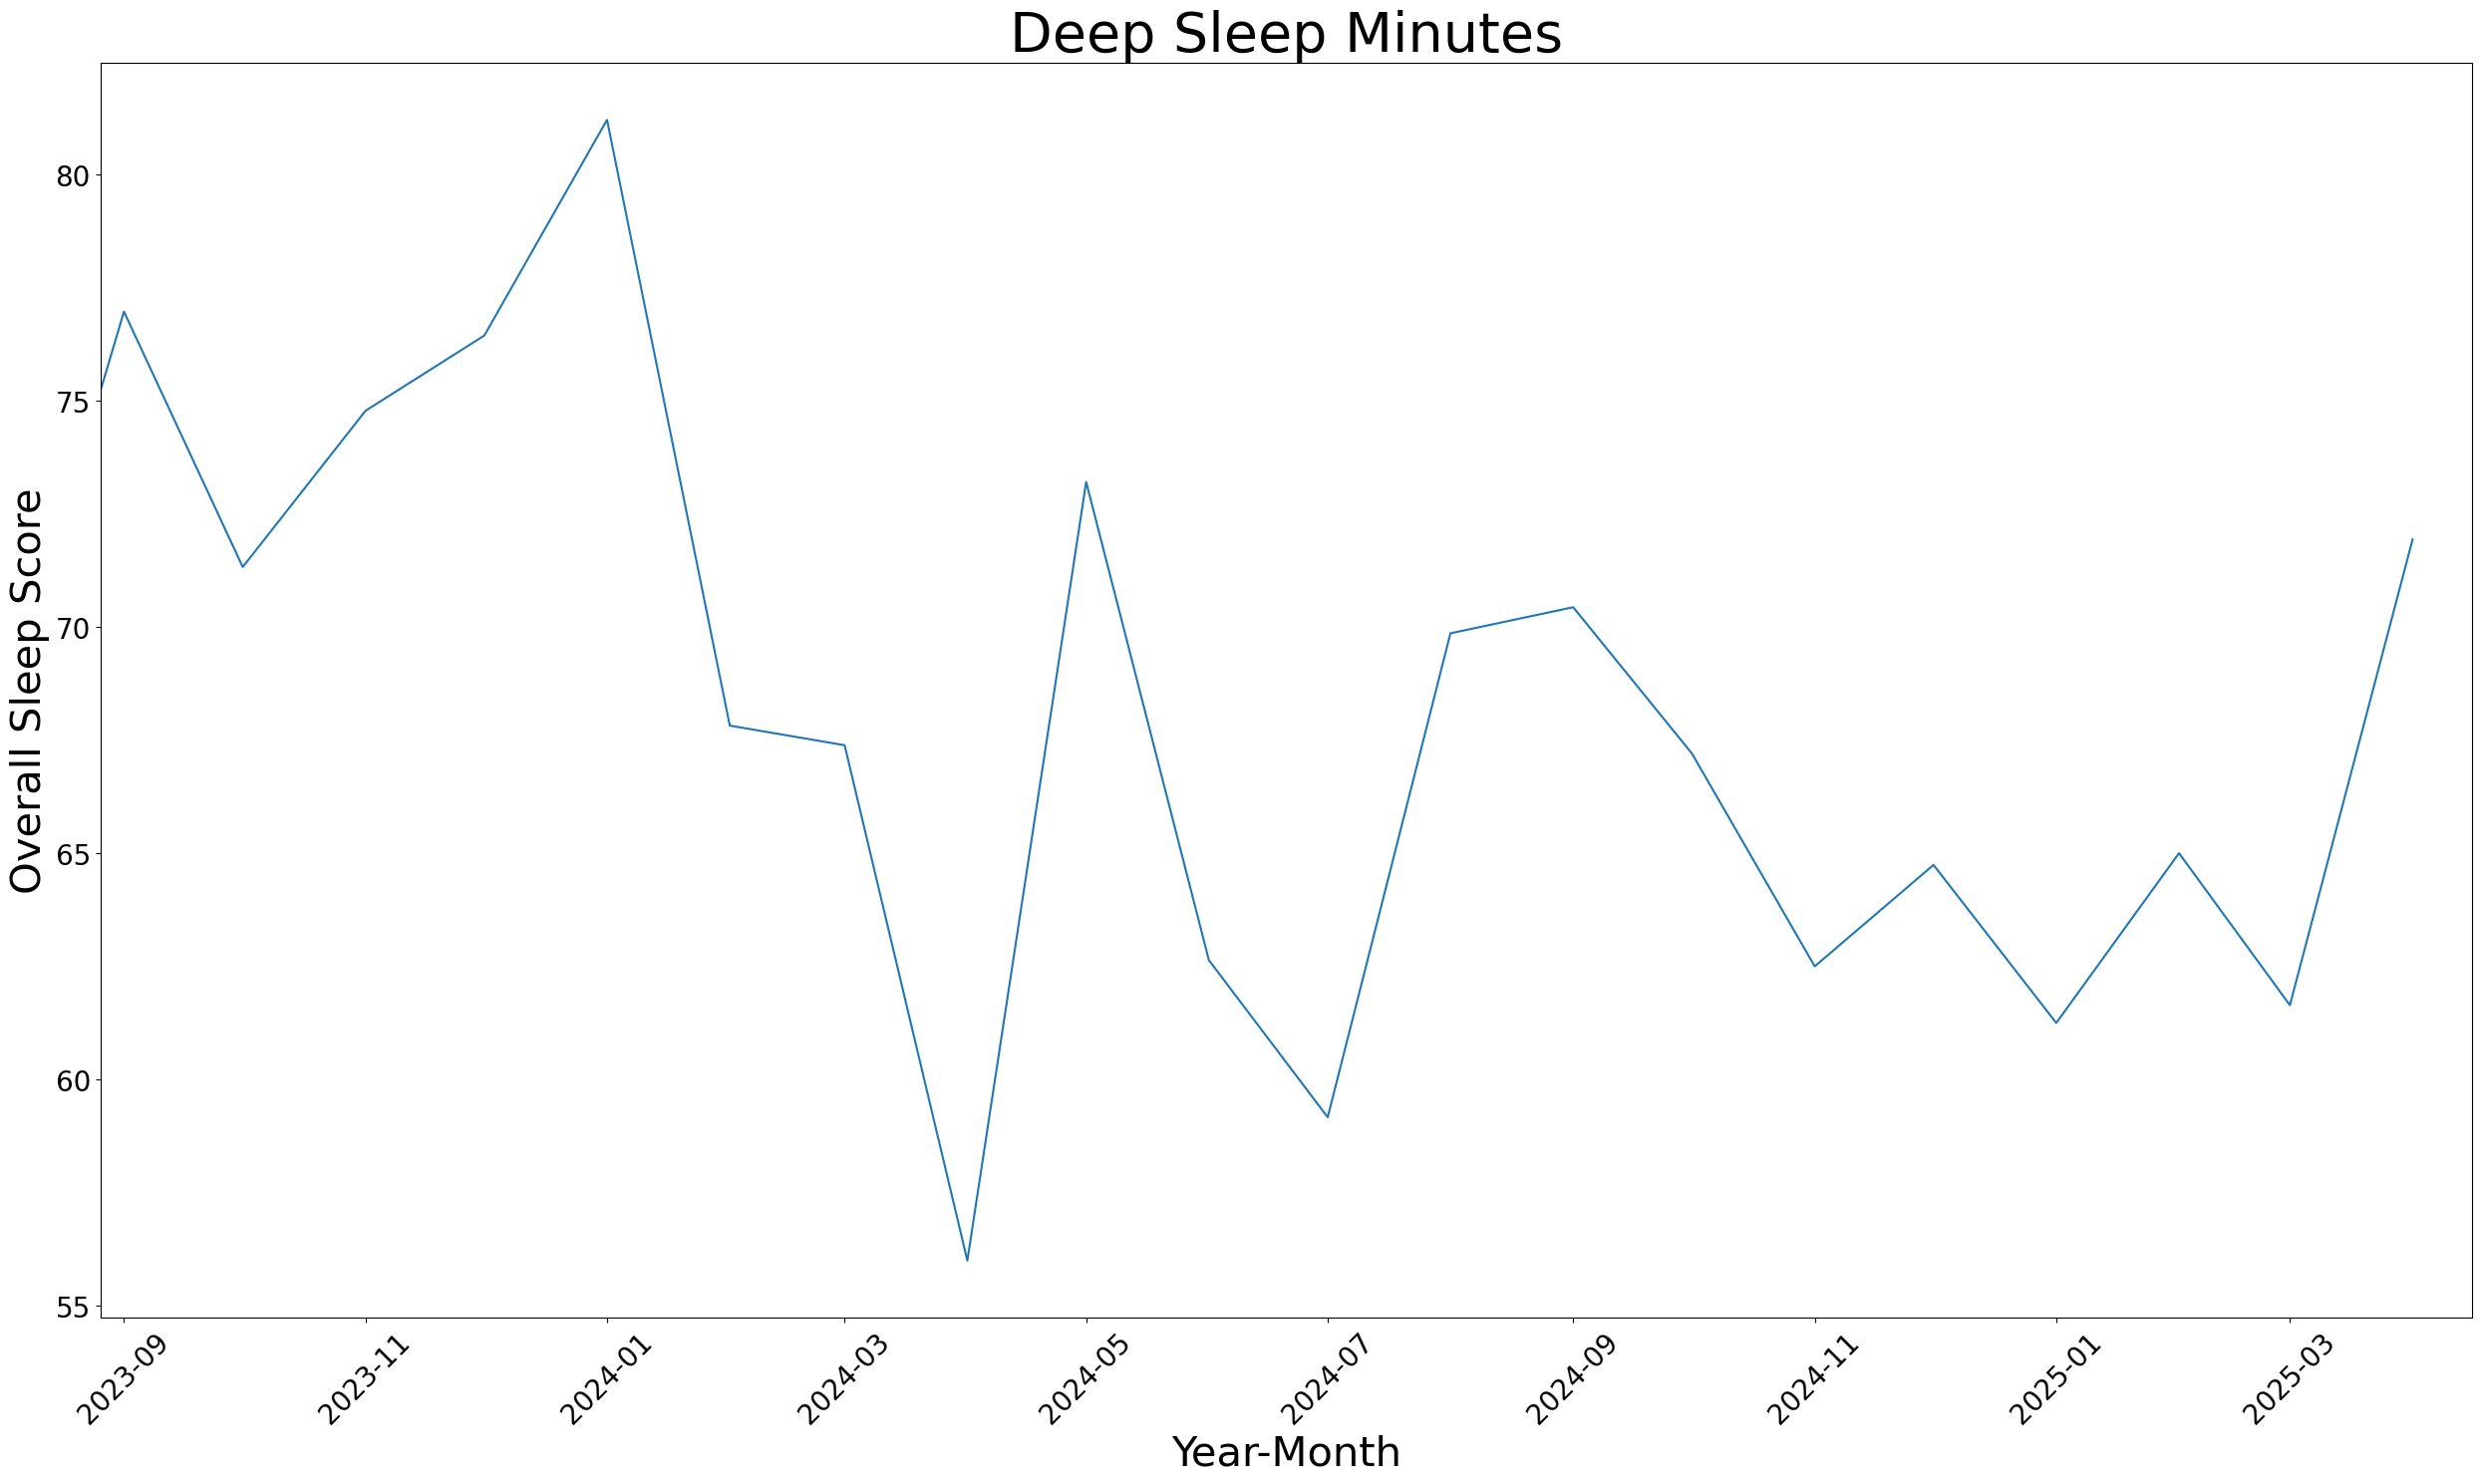

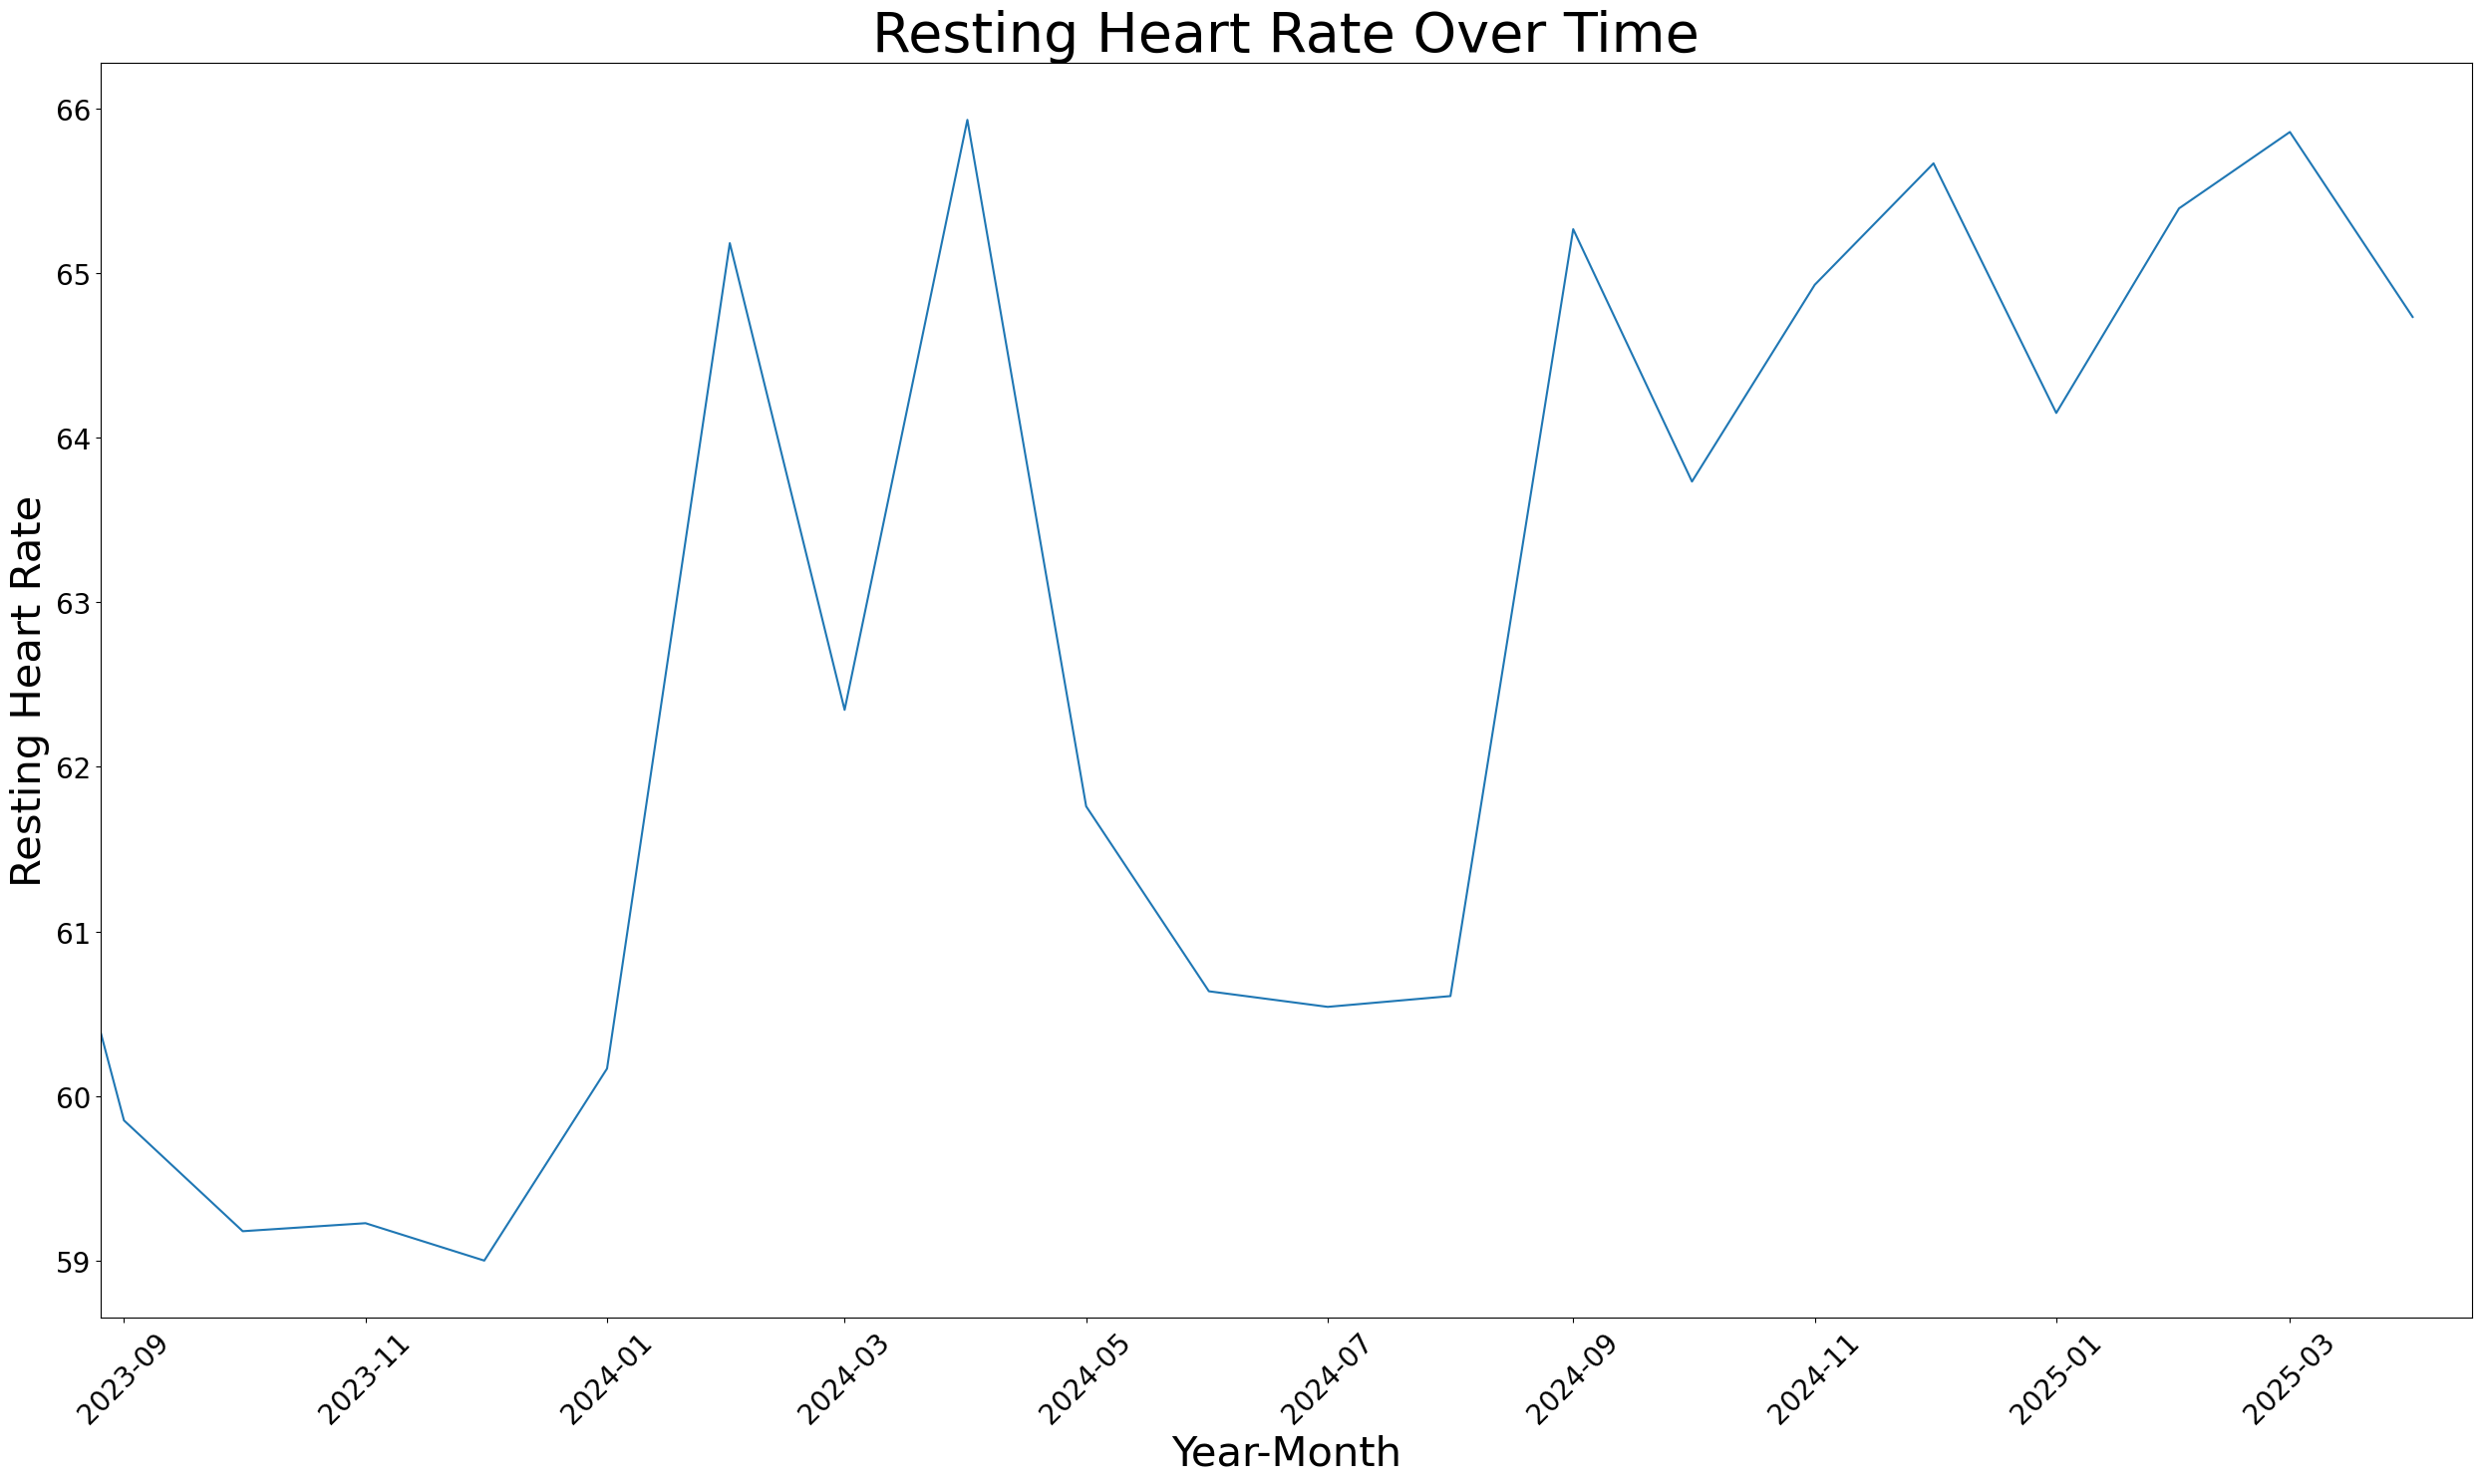

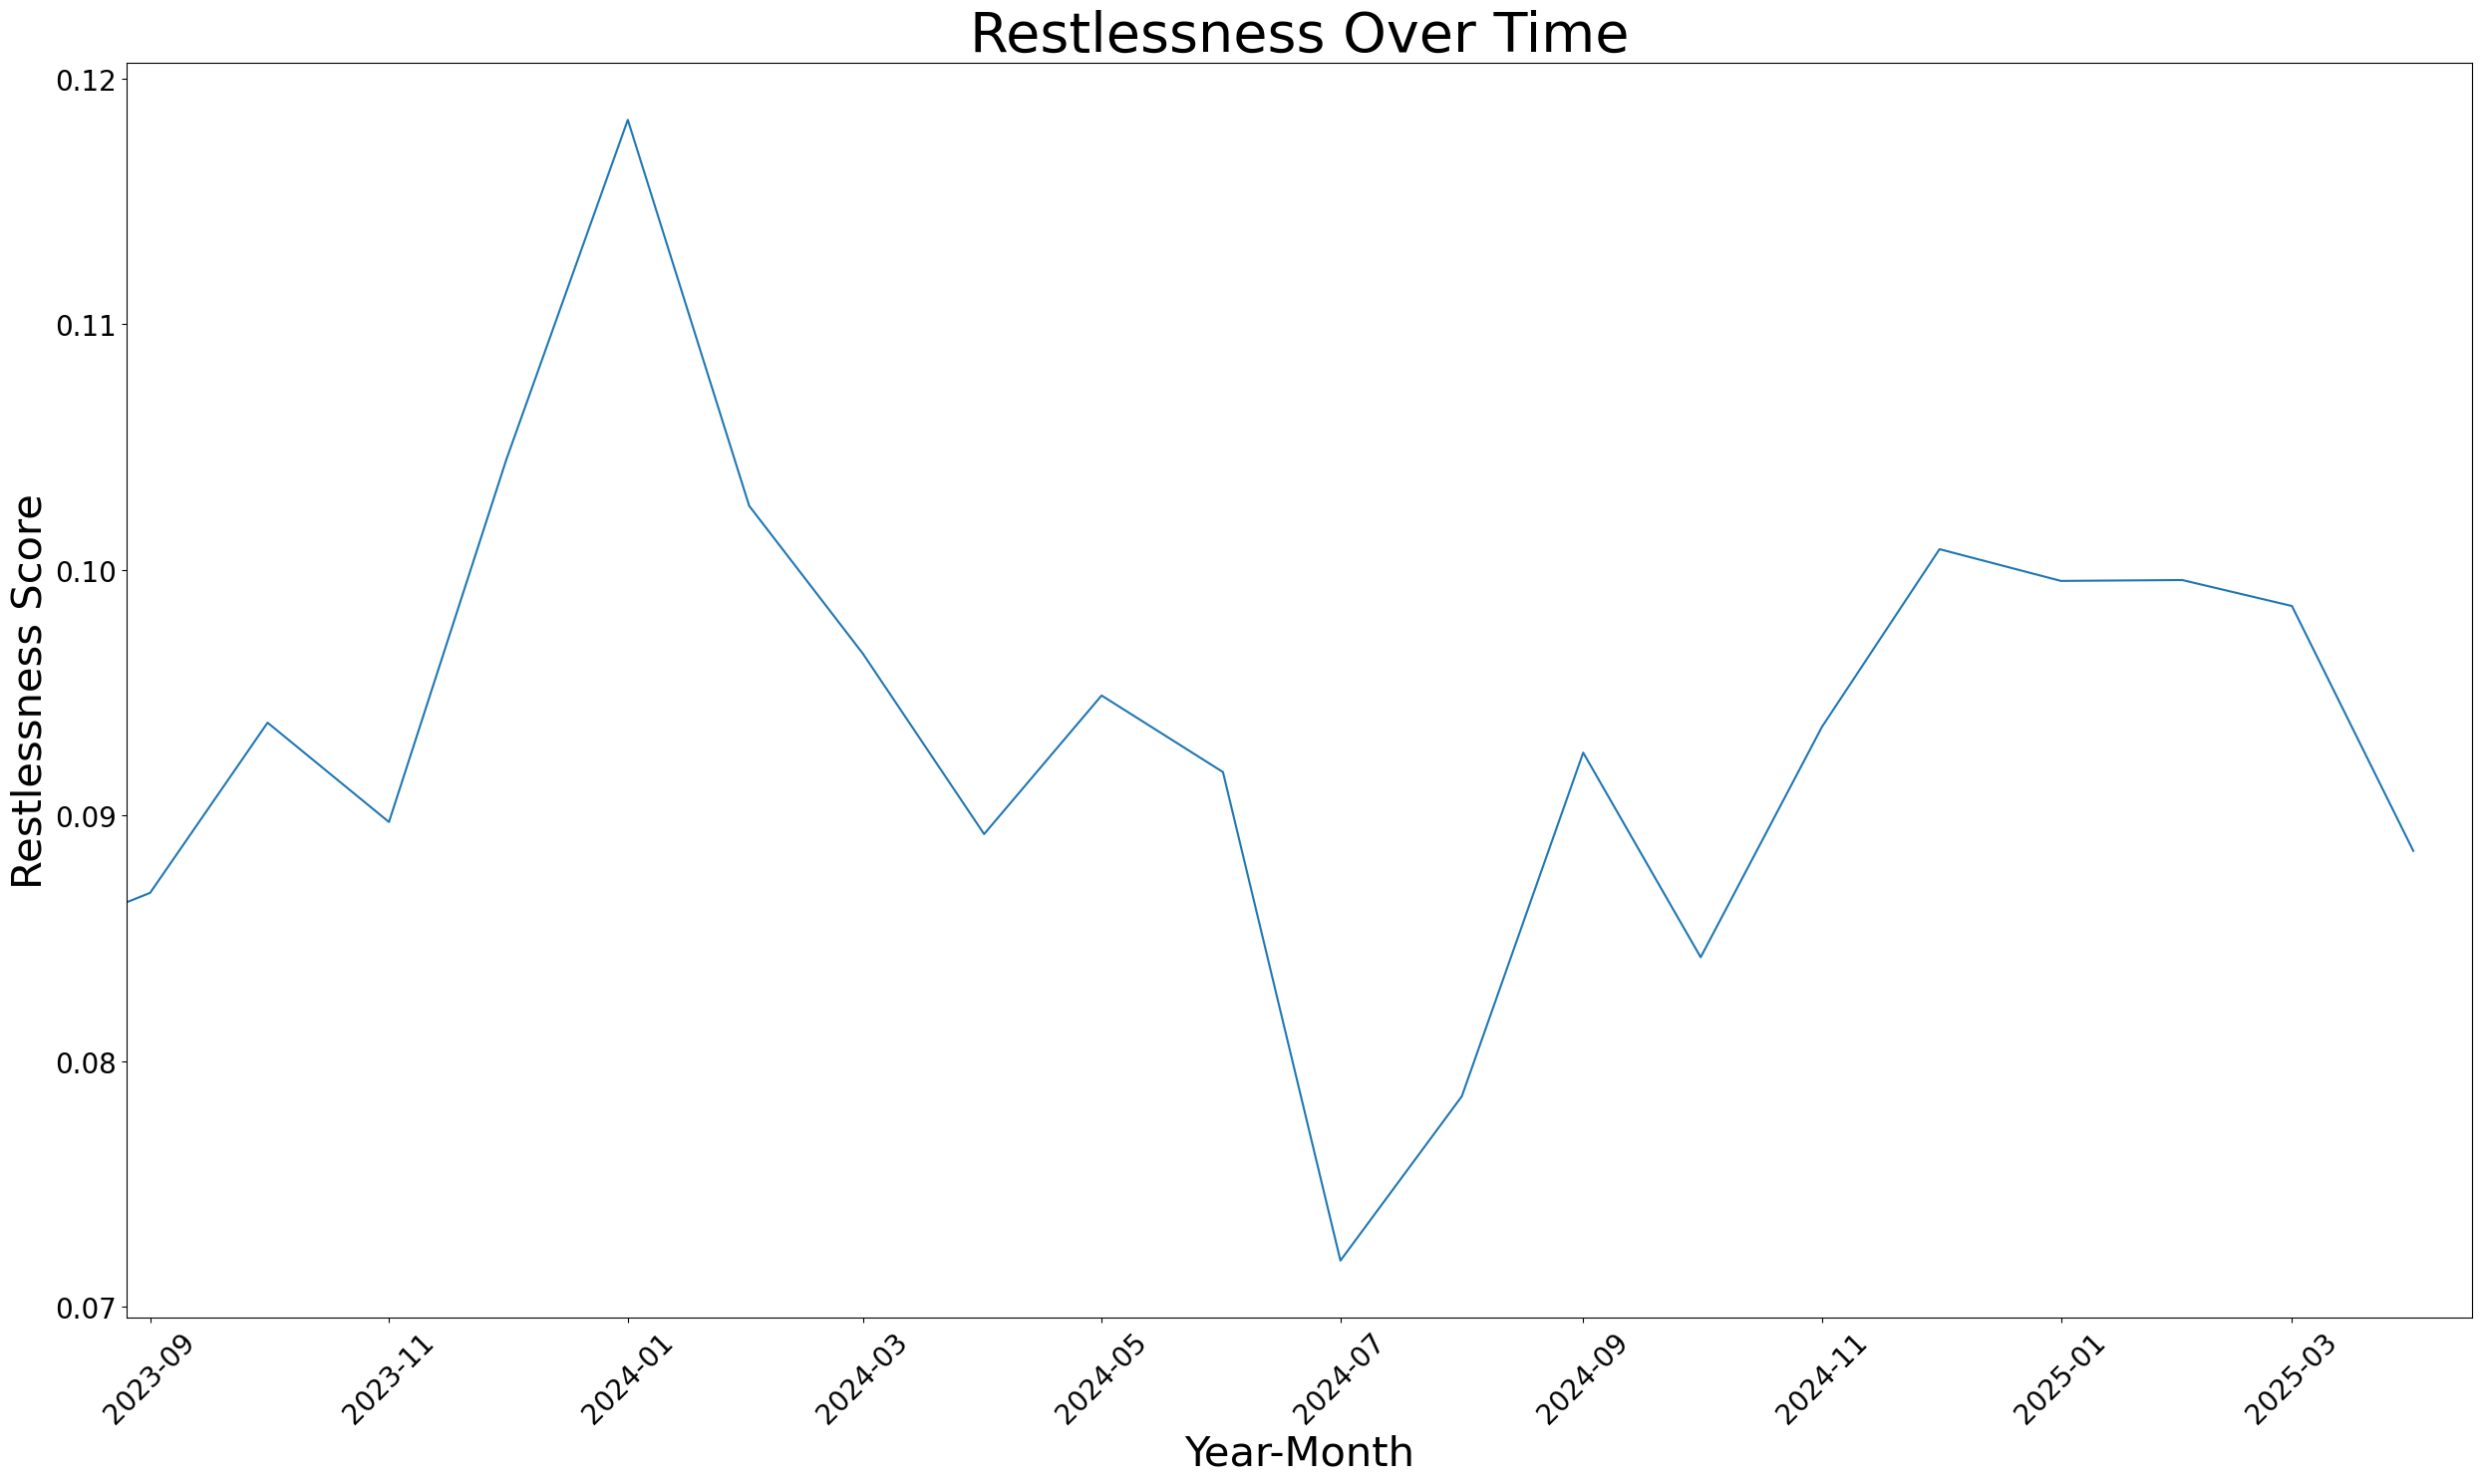

In [198]:
# Line graphs
utils.create_line_graph(merged_df.index, merged_df["overall_score"], "Sleep Quality", "Year-Month", "Overall Sleep Score")
utils.create_line_graph(merged_df.index, merged_df["revitalization_score"], "Revitalization Over Time", "Year-Month", "Revitalization Score")
utils.create_line_graph(merged_df.index, merged_df["deep_sleep_in_minutes"], "Deep Sleep Minutes", "Year-Month", "Overall Sleep Score")
utils.create_line_graph(merged_df.index, merged_df["resting_heart_rate"], "Resting Heart Rate Over Time", "Year-Month", "Resting Heart Rate")
utils.create_line_graph(merged_df.index, merged_df["restlessness"], "Restlessness Over Time", "Year-Month", "Restlessness Score")

It is fascinating to see how my sleep patterns have behaved over time. Variations will occur, but sometimes changes will stay.  
We can easily see that my resting heart rate changed over time. 
Let's get a better look at my overall sleep score for each month:

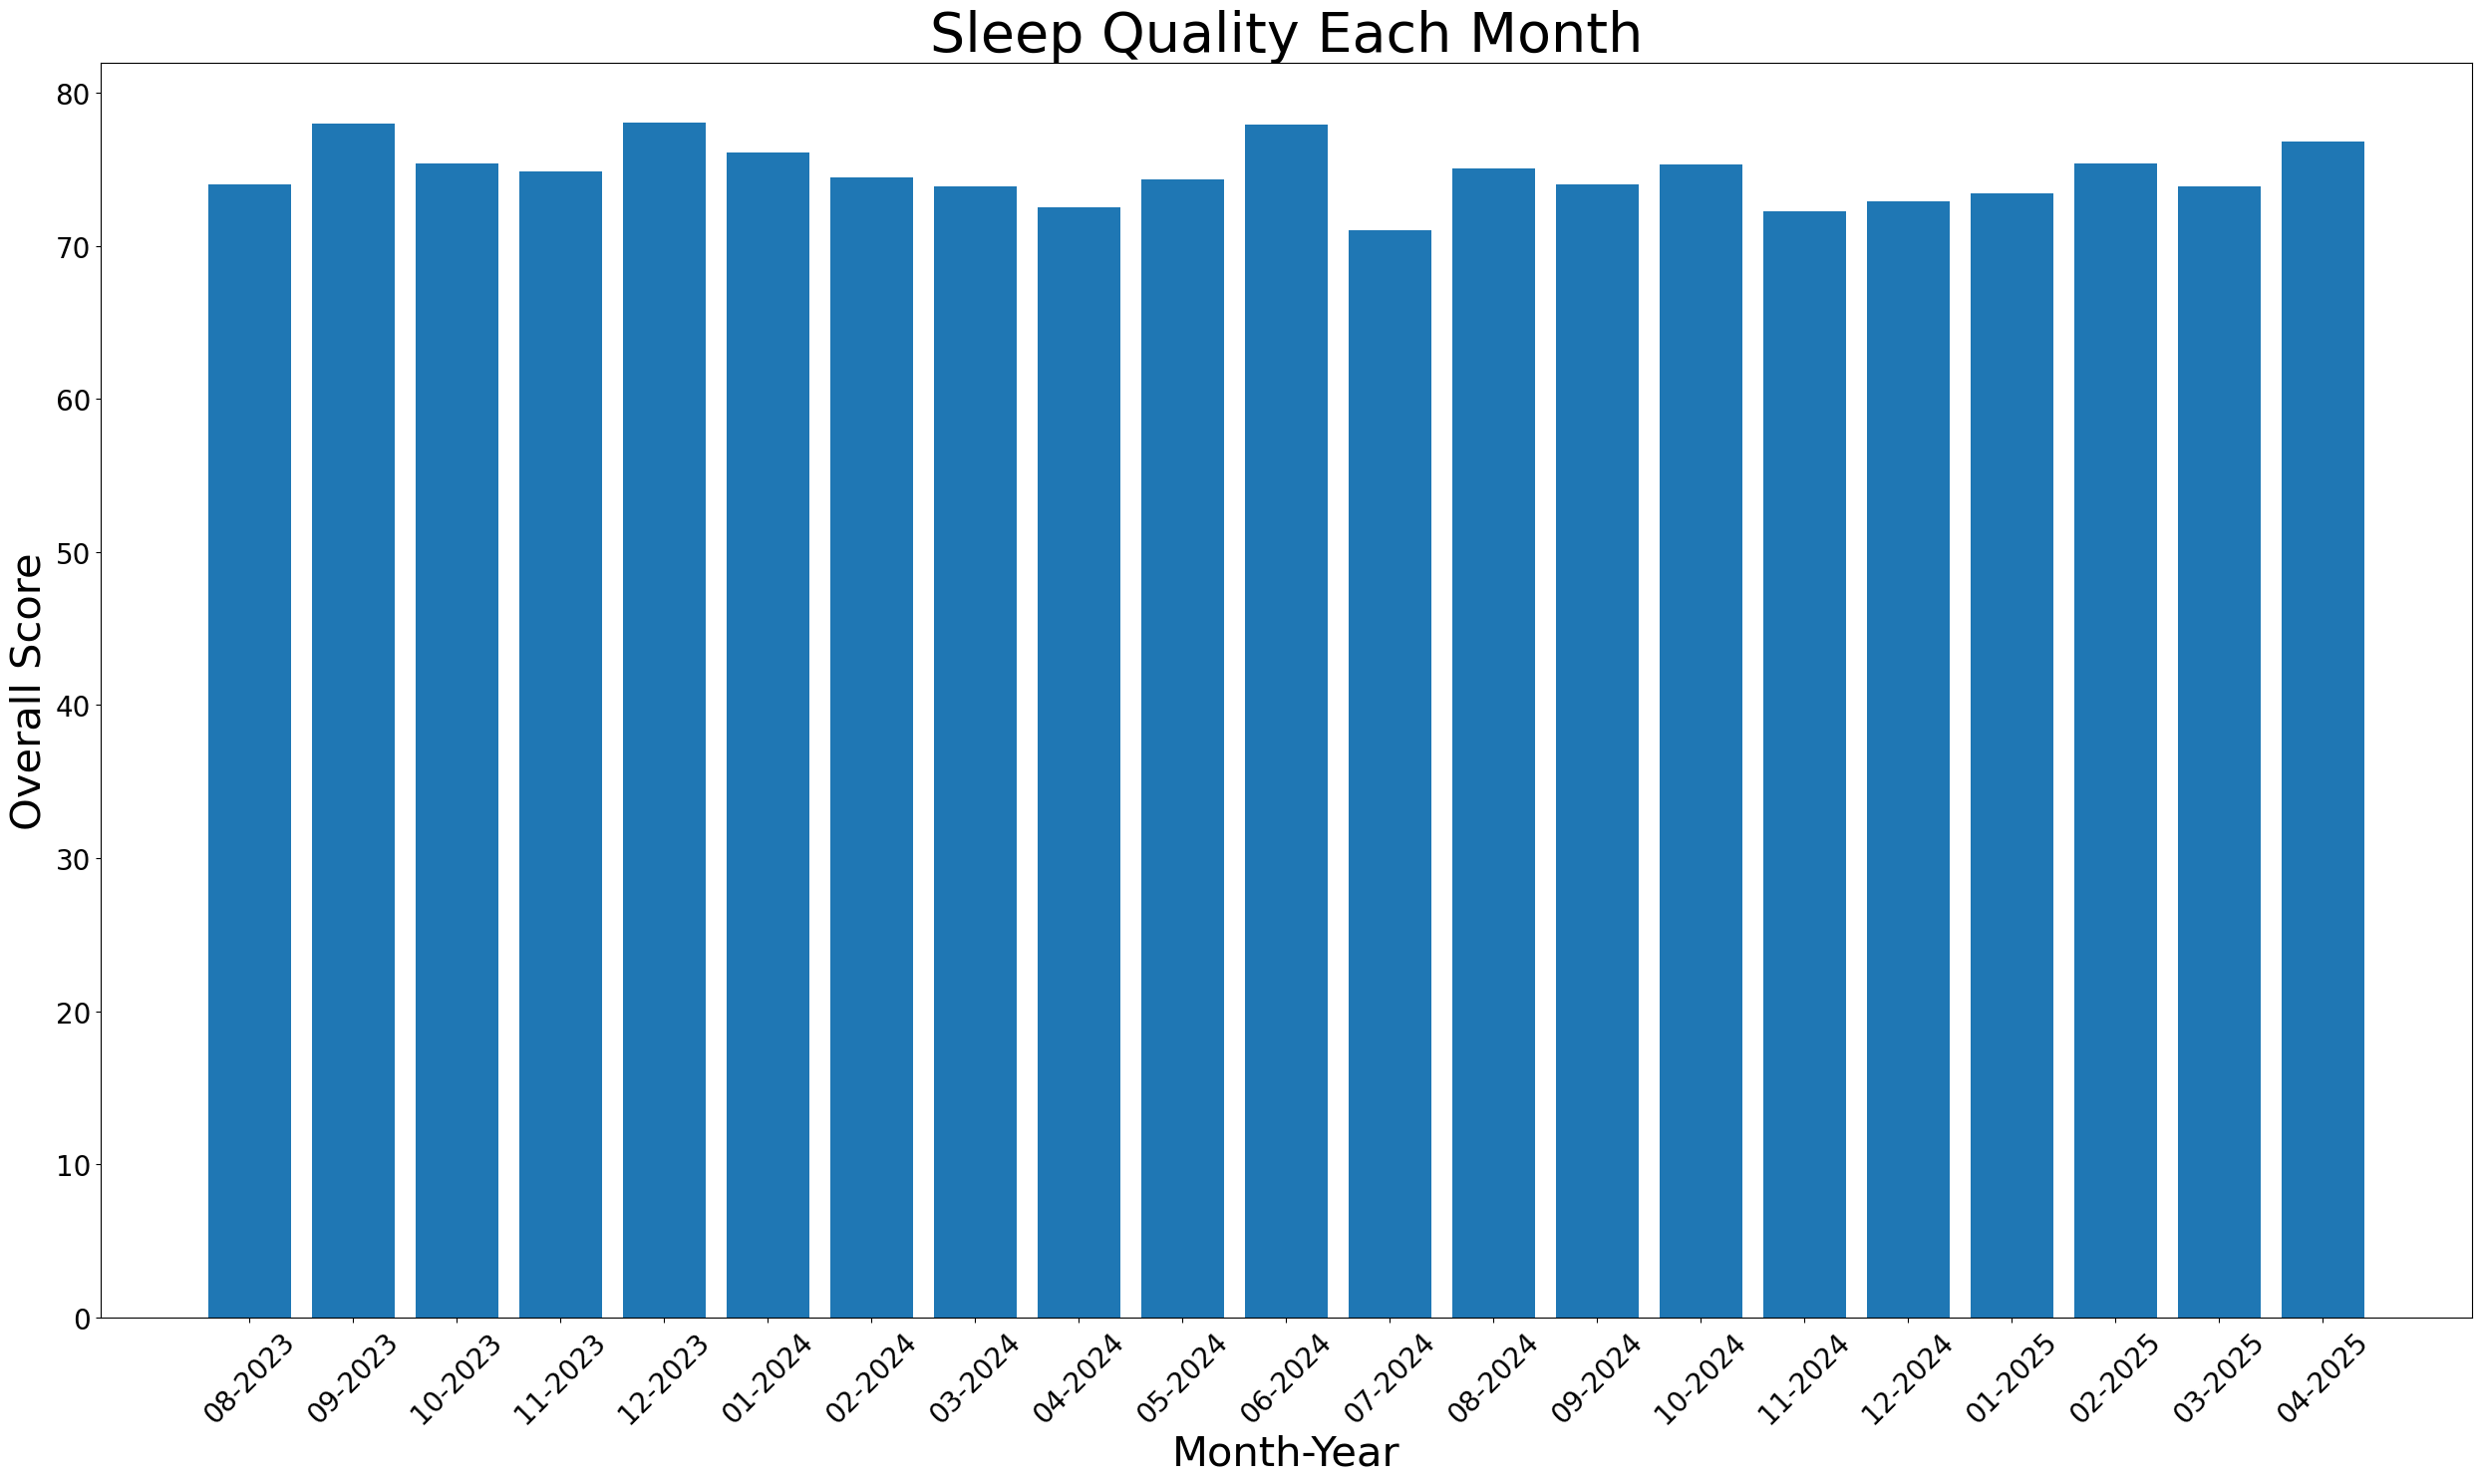

In [199]:
# Bar graphs
utils.create_bar_chart(dates, merged_df["overall_score"], "Sleep Quality Each Month", "Month-Year", "Overall Score")

### Correlation Visualization
Let's take a closer look at the possible correlations between features. We can use a correlation matrix to get a clear view. We'll first need a DataFrame without the (string) class, but we might as well set up our feature matrix and target array.

In [200]:
corr_df = just_school.corr()
corr_df.style.background_gradient(cmap="bwr")

,year,month,day,overall_score,revitalization_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,tavg,tmin,tmax,prcp,wdir,wspd,pres
year,1.000000,-0.662268,0.022051,-0.074408,-0.074408,-0.127734,0.595728,0.086460,-0.275255,-0.314796,-0.231767,-0.059280,0.022359,0.204724,0.003662
month,-0.662268,1.000000,-0.151297,0.060133,0.060133,0.080092,-0.310473,-0.135089,0.359329,0.413160,0.300160,0.069822,0.089603,-0.106153,0.052200
day,0.022051,-0.151297,1.000000,0.015053,0.015053,0.048308,-0.046130,-0.039867,-0.023351,-0.010039,-0.026115,-0.041025,-0.024656,0.044444,0.038498
overall_score,-0.074408,0.060133,0.015053,1.000000,1.000000,0.538034,-0.037160,-0.362566,0.054867,0.053881,0.058901,-0.042336,-0.018773,0.032568,0.006489
revitalization_score,-0.074408,0.060133,0.015053,1.000000,1.000000,0.538034,-0.037160,-0.362566,0.054867,0.053881,0.058901,-0.042336,-0.018773,0.032568,0.006489
deep_sleep_in_minutes,-0.127734,0.080092,0.048308,0.538034,0.538034,1.000000,-0.131250,-0.023612,0.027136,0.028297,0.033605,-0.070699,-0.041625,-0.076557,0.011355
resting_heart_rate,0.595728,-0.310473,-0.046130,-0.037160,-0.037160,-0.131250,1.000000,-0.018828,-0.034819,0.000190,-0.060616,-0.012766,0.082388,0.197124,-0.066186
restlessness,0.086460,-0.135089,-0.039867,-0.362566,-0.362566,-0.023612,-0.018828,1.000000,-0.211093,-0.207349,-0.210480,-0.008595,-0.091104,-0.104874,0.067962
tavg,-0.275255,0.359329,-0.023351,0.054867,0.054867,0.027136,-0.034819,-0.211093,1.000000,0.947006,0.968274,-0.147083,0.058856,0.182431,-0.326096
tmin,-0.314796,0.413160,-0.010039,0.053881,0.053881,0.028297,0.000190,-0.207349,0.947006,1.000000,0.850952,-0.017357,0.123603,0.254925,-0.409534


Alright, I can explain. After my premium plan expired, it looks like they simply combined my "composition_score", "revitalization_score", and "duration_score" into the "revitalization_score". For my modeling later, I will be removing "revitalization_score" in addition to the features that don't correlate too well.  
It is somewhat funny that my heart rate decently correlates with the year becasue it did change each year. However, it is surprising that it doesn't correlate well with overall score, revitalization, or deep sleep.  
Restlessness, as expected, has a slight inverse correlation with overall score.  
We can also see that temperature has a notable inverse correlation with restlessness (as temperature increases, my restlessness decreases), which is somewhat surprising because I prefer sleeping in colder temperatures. Perhaps my body needs to warm up before it can rest, or the temperature indirectly influences my sleep?

### Hypothesis Testing
Let's perform some hypothesis tests to see how much my sleep patterns have changed over time. I'd like to examine the possible changes in my deep sleep, restlessness, and overall score. 

#### Deep Sleep
Let's see if I my deep sleep duration changed between years and semesters. We'll first see if it changed between my sophomore fall and my freshman fall.
1. Hypotheses:
    * $H_0: \mu _{soph} = \mu _{fresh}$
    * $H_1: \mu _{soph} \neq \mu _{fresh}$
1. Let $\alpha = 0.05$
1. We'll be using scipy's `ttest_ind()`
    * While the subject (me) in both samples is the same, the timing isn't, so the two samples aren't truly independent.
    This will apply to all of the following hypothesis tests
1. Decision rule:
    * if $p_{val}$ $< \alpha$, then reject $H_0$
    * else, do not reject $H_0$

In [201]:
t, p_val = stats.ttest_ind(fall_2024["deep_sleep_in_minutes"], fall_2023["deep_sleep_in_minutes"])
alpha = 0.05
print("t:", t)
print("p_val:", p_val)
if p_val < alpha:
    print("reject H_0; I had different deep sleep duration during my sophomore fall than my freshman fall")
else:
    print("do not reject H_0; I didn't have different deep sleep duration during my sophomore fall than my freshamn fall")

t: -1.7596951546668582
p_val: 0.08002758359016633
do not reject H_0; I didn't have different deep sleep duration during my sophomore fall than my freshamn fall


A year didn't change this my deep sleep, or maybe summer break allowed me to get a fresh start.  
 Let's see if there was a change between Fall 2023 and Spring 2024.
1. Hypotheses:
    * $H_0: \mu _{spring24} = \mu _{fall23}$
    * $H_1: \mu _{spring24} \neq \mu _{fall23}$
1. Let $\alpha = 0.05$
1. We'll be using scipy's `ttest_ind()`
1. Decision rule:
    * if $p_{val}$ $< \alpha$, then reject $H_0$
    * else, do not reject $H_0$

In [202]:
t, p_val = stats.ttest_ind(spring_2024["deep_sleep_in_minutes"], fall_2023["deep_sleep_in_minutes"])
alpha = 0.05
print("t:", t)
print("p_val:", p_val)
if p_val < alpha:
    print("reject H_0; I had different deep sleep duration during my freshman spring than my freshman fall")
else:
    print("do not reject H_0; I didn't have different deep sleep duration during my freshman spring than my freshamn fall")

t: -2.488808871161492
p_val: 0.01366344831203878
reject H_0; I had different deep sleep duration during my freshman spring than my freshman fall


This makes sense because the spring semester drags slightly longer than the fall semsester, and I had a more challenging schedule. Additionally, it is easy for me to notice that I have gotten less sleep overall as I spend more time here. (I currently less than 7 hours of quality sleep, and I don't count sleeping in as quality sleep.) 

#### Restlessness
We have evidence to suggest that there isn't much significant difference in deep sleep between fall semesters, but there was a significant difference between spring and fall of the same school year.  
Was I more restless in Spring 2024 than in Fall 2023? We can do a one-tailed, independent, two sample test. 
1. Hypotheses:
    * $H_0: \mu _{spring24} = \mu _{fall23}$
    * $H_1: \mu _{spring24} \neq \mu _{fall23}$
1. Let $\alpha = 0.05$
1. We'll be using scipy's `ttest_ind()`
1. Decision rule:
    * if $\frac{p_{val}}{2}$ $< \alpha$, then reject $H_0$
    * else, do not reject $H_0$

In [203]:
t, p_val = stats.ttest_ind(spring_2024["restlessness"], fall_2023["restlessness"])
p_val *= 1/2
alpha = 0.05
print("t:", t)
print("p_val:", p_val)
if p_val < alpha:
    print("reject H_0; I experienced more restlessness during my freshman spring than my freshman fall")
else:
    print("do not reject H_0; I didn't experience more restlessness during my freshman spring than my freshman fall")

t: 2.3346904425521275
p_val: 0.010293902594655242
reject H_0; I experienced more restlessness during my freshman spring than my freshman fall


Seems like the Spring Semester drag is difficult, Christmas break wasn't long enough, and/or there are other personal factors having a significant effect. In fact, I wasn't doing well mentally during that spring.  
For fun, let's apply the same test to my sophomore semesters:

In [204]:
t, p_val = stats.ttest_ind(spring_2025["restlessness"], fall_2024["restlessness"])
p_val *= 1/2
alpha = 0.05
print("t:", t)
print("p_val:", p_val)
if p_val < alpha:
    print("reject H_0; I experienced more restlessness during my sophomore spring than my sophomore fall")
else:
    print("do not reject H_0; I didn't experience more restlessness during my sophomore spring than my sophomore fall")

t: 1.1594588145007143
p_val: 0.12389404881709315
do not reject H_0; I didn't experience more restlessness during my sophomore spring than my sophomore fall


Now this tells an interesting story! I can confirm that I'm doing a lot better mentally than I was a year ago. I'll personally advocate counseling; make use of it here, especially because it's free with your tuition.  

#### Overall Score
Lastly, let's see if my overall sleep quality has changed between this semester and first semester. Let's apply a two-tailed, independent, test.
1. Hypotheses:
    * $H_0: \mu _{spring25} = \mu _{fall23}$
    * $H_1: \mu _{spring25} \neq \mu _{fall23}$
1. Let $\alpha = 0.05$
1. We'll be using scipy's `ttest_ind()`
1. Decision rule:
    * if $p_{val}$ $< \alpha$, then reject $H_0$
    * else, do not reject $H_0$

In [205]:
t, p_val = stats.ttest_ind(spring_2025["overall_score"], fall_2023["overall_score"])
alpha = 0.05
print("t:", t)
print("p_val:", p_val)
if p_val < alpha:
    print("reject H_0; I had different sleep quality during my sophomore spring than my freshman fall")
else:
    print("do not reject H_0; I didn't have different sleep quality during my sophomore spring than my freshamn fall")

t: -1.3994265932016765
p_val: 0.1634755941321322
do not reject H_0; I didn't have different sleep quality during my sophomore spring than my freshamn fall


There isn't evidence to suggest that my overall sleep quality during this semester differed from the overall sleep quality of my first semester. I suppose there's some consistency with my sleep quality. 

## Machine Learning

As a reminder, I'd like to set my decoded overall sleep score as the class. The distribution will be excellent, good, fair, and poor.  
I'll admit, the correlations weren't as strong as I suspected, but I may be able to create a decent model with the feature matrix. I predict that my models' accuracies will be between 50-70%.  
Let's prepare my data.

In [206]:
# Decode overall sleep score
classified_df = utils.decode_sleep_scores(initial_merged_df)
classified_df.to_csv("classified_df.csv")

# Create the two groups
y = classified_df.pop("overall_score")
X = classified_df

In [207]:
print(X.head())
print(y.head())

            year  month  day  revitalization_score  deep_sleep_in_minutes  \
date                                                                        
2025-04-16  2025      4   16                    76                   55.0   
2025-04-15  2025      4   15                    71                   59.0   
2025-04-14  2025      4   14                    84                  122.0   
2025-04-13  2025      4   13                    73                   79.0   
2025-04-12  2025      4   12                    70                   14.0   

            resting_heart_rate  restlessness  tavg  tmin  tmax   prcp   wdir  \
date                                                                           
2025-04-16                  64      0.083240  51.1  41.0  62.1  0.000  355.0   
2025-04-15                  65      0.093929  52.9  34.5  69.6  0.000  191.0   
2025-04-14                  65      0.105641  50.4  34.0  64.8  0.000   52.0   
2025-04-13                  65      0.063325  45.1  32.0  59